In [3]:
############################################################################
################       █████   █████████  ███████████       ################ 
################      ░░███   ███░░░░░███░█░░░███░░░█       ################ 
################       ░███  ███     ░░░ ░   ░███  ░        ################ 
################       ░███ ░███             ░███           ################ 
################       ░███ ░███             ░███           ################ 
################       ░███ ░░███     ███    ░███           ################ 
################       █████ ░░█████████     █████          ################ 
################       ░░░░░   ░░░░░░░░░     ░░░░░          ################ 
############################################################################
########                IRI PROGRESSION MODEL (MPEDG)             ##########
################           Project: R27-252 EV             #################
########     Originally written by: Aravind Ramakhrishnan        ###########
############################################################################

# Created on Sat May 28 21:10:59 2022
# Last modified on Fri Jul 27 9:10:59 2024
# @author: Johann-Cardenas

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import time

# Import modules
import Temperature_Parameters as TP
import Expected_strain as ES
import Rut_calc_RP_v4 as RC_V4
import Fatigue_calc as FC
import IRI_calc

# Start time tracker
start = time.time()

In [2]:
# =============================================================================
# INITIALIZING PARAMETERS
# =============================================================================
bin_npl = np.linspace(-24.5,24.5,99)              # Bin for non-platoon
bin_pl = np.array([[-24,-22],[-1,1],[22,24]])     # Bin for platoon
prob_pl = np.array([1/3,1/3,1/3])                 # Probability for platoon
PS = 3                                            # Platoon Size
PL = 75                                           # Penetration Level in %
GR = 0.01                                         # Traffic growth rate
AP = 10                                           # Analysis period (years)
RPFactor = 0.0096                                 # Roughness Progression Factor (assumption)

In [3]:
# =============================================================================
# TRAFFIC AND STRUCTURE
# =============================================================================
Traffic = pd.ExcelFile('Traffic.xlsx')
Sheet_Names = Traffic.sheet_names
AMDTT, AADTT, Axles_per_TruckClass, Normalized_Truck_Dist, Single_Axle, Tandem_Axle = [Traffic.parse(i) for i in Sheet_Names]
P_si = Single_Axle['Bin_Center_kN'].values/1./2.
P_ta = Tandem_Axle['Bin_Center_kN'].values/1./2.
PP = [P_si, P_ta]
Structure = ['NSS','NTS']                      # Type of Structure, ThinS, ThinW, ThickS, ThickW
AADTT = AADTT.values[0][0]
AADTT_yearly = [AADTT*(1+GR)**i for i in range(AP)]

In [4]:
# =============================================================================
# INITIALIZING DISTRESS PARAMETERS
# =============================================================================
rutfinalAC = []
maxrutAC = [0]
rutfinalBase = []
maxrutBase = [0]
rutfinalSubg = []
maxrutSubg = [0]
rutfinal = [0]
rutfinalAC_sd = [0]
rutfinalBase_sd = [0]
rutfinalSubg_sd = [0]
rutfinal_sd = [0]
iteration = 0
FC_total_max = [0]
DI_BU = np.zeros((99,))
DI_TD = np.zeros((99,))

In [5]:
# =============================================================================
# MAIN CODE
# =============================================================================
for yy in range(AP):
    AADTT_y = AADTT_yearly[yy]
    print(yy)
    for mm in range(12):
        N_ycm_si, N_ycm_ta, N_ycm_tr = 0, 0, 0
        Temp = TP.temperature(mm)
        Resp = pd.ExcelFile('FE_INPUTS-'+Temp+'.xlsx').parse(Structure)
        Single = Resp[Structure[0]] # Single Axle Strain Profile for 12 kips axle load
        Tandem = Resp[Structure[1]] # Tandem Axle Strain Profile for 34 kips axle load
        
        for cc in range(10):
            AADTT_yc = AADTT_y * Normalized_Truck_Dist['Percent_AADTT'][cc]/100.
            TT_ycm = 30. * AADTT_yc * AMDTT['Class_' + str(cc+4)][mm]/100.
            Si = TT_ycm * Axles_per_TruckClass['Single'][cc]
            Ta = TT_ycm * Axles_per_TruckClass['Tandem'][cc]
            N_ycm_si += Si * Single_Axle['Class_' + str(cc+4)].values/100.
            N_ycm_ta += Ta * Tandem_Axle['Class_' + str(cc+4)].values/100.
        
        NN = [N_ycm_si, N_ycm_ta]
        iteration += 1        
        # =============================================================================
        # Truck parameters initialization        
        # =============================================================================
        Total_Trucks = np.sum(NN[0]) # Total Number of Trucks
        Pl_Trucks = int(Total_Trucks*PL/100) # Total Number of Trucks in platoon
        Pl_groups = int(Pl_Trucks/PS) # Total number of platoons
        Npl_Trucks = int(Total_Trucks - Pl_groups*PS) # Manual Traffic
        s_normal = np.random.normal(0,10,Npl_Trucks)
        b = np.histogram(s_normal,bins=np.linspace(-24.75, 24.75,100))
        freq_npl = b[0]
        freq_pl = []
        for i in range(len(bin_pl)):
            s = np.random.uniform(bin_pl[i][0],bin_pl[i][1],int(prob_pl[i]*Pl_groups))
            b = np.histogram(s,bins=np.linspace(bin_pl[i][0], bin_pl[i][1],6))
            freq_pl.append(b[0])
        freq_pl = np.array(freq_pl)
        IP_npl = np.concatenate([(bin_npl[i]*np.ones((freq_npl[i],))) 
                                       for i in range(len(freq_npl))])
        np.random.shuffle(IP_npl)
        locs = np.linspace(bin_pl[:,0],bin_pl[:,1],5).T
        IP_pl = np.concatenate([(locs[i][j]*np.ones((freq_pl[i][j],)))
                 for i in range(len(freq_pl)) for j in range(len(freq_pl[0]))])
        np.random.shuffle(IP_pl)
        InputMat = np.append(PS*np.ones(Pl_groups),np.ones(sum(freq_npl)))
        #np.random.shuffle(InputMat)
        # =============================================================================
        # Expected Strain
        # =============================================================================
        FER_rut_AC = ES.Expected(freq_npl, bin_npl, freq_pl, bin_pl, PS, Single, Tandem, RPFactor)
        cols = len(FER_rut_AC) # Transverse Strain Profile bins
        FER_rut_UB = ES.Expected(freq_npl, bin_npl, freq_pl, bin_pl, PS, Single, Tandem, 1)
        # =============================================================================
        # Rutting calculation        
        # =============================================================================
        if iteration == 1 and (Structure == ['NSS','NTS'] or Structure == ['NSW','NTW']):
            rutAC_D, rutAC_ref = np.zeros((5,cols)), np.zeros((5,cols))
            rutB_D = np.zeros((3,cols))
            rutS_D = np.zeros((2,cols))
        elif iteration == 1 and (Structure == ['KSS','KTS'] or Structure == ['KSW','KTW']):
            rutAC_D, rutAC_ref = np.zeros((7,cols)), np.zeros((7,cols))
            rutB_D = np.zeros((3,cols))
            rutS_D = np.zeros((2,cols))
        rutAC_D, rutAC_ref = RC_V4.ACrutting(Structure, Temp, FER_rut_AC, Single, Tandem, 
                                  InputMat, RPFactor, rutAC_D, rutAC_ref,IP_npl,IP_pl)                       
        rutfinalAC.append(np.sum(rutAC_D,0))
        maxrutAC.append(max(np.sum(rutAC_D,0)))
        rutB_D, rutS_D = RC_V4.Unboundrutting(Structure, Temp, FER_rut_UB, Single, Tandem, 
                                              InputMat, rutB_D, rutS_D,IP_npl,IP_pl)
        rutfinalBase.append(np.sum(rutB_D,0))
        maxrutBase.append(max(np.sum(rutB_D,0)))
        rutfinalSubg.append(np.sum(rutS_D,0))
        maxrutSubg.append(max(np.sum(rutS_D,0)))
        # =============================================================================
        # Fatigue Calculation
        # =============================================================================
        BU_Nf_s, BU_Nf_t = FC.Nf_cracking(Structure, Single, Tandem, InputMat, 'BU')
        TD_Nf_s, TD_Nf_t = FC.Nf_cracking(Structure, Single, Tandem, InputMat, 'TD')
        DI_bu, DI_td = ES.Expected_Nf(freq_npl, bin_npl, freq_pl, bin_pl, PS, 
                                    [1/0.44/BU_Nf_s,1/TD_Nf_s], [1/0.44/BU_Nf_t,1/TD_Nf_t])
        DI_BU += DI_bu
        DI_TD += DI_td
        FC_BU = FC.FC_BU_(DI_BU, Structure)
        FC_TD = FC.FC_TD_(DI_TD)
        DI_prev_BU, DI_prev_TD = DI_BU, DI_TD
        FC_total_max.append(max(FC_BU+FC_TD*100/5280.))

0


c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:102: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:102: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar di

1


c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:102: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:102: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar di

2


c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:102: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:102: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar di

3


c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:102: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:102: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar di

4


c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:102: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:102: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar di

5


c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:102: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:102: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar di

6


c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:102: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:102: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar di

7


c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:102: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:102: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar di

8


c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:102: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:102: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar di

9


c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:102: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:102: RuntimeWarning: invalid value encountered in scalar divide
  Coeff[i] = (RutprevAC[maxloc])/(RutprevAC_ref[maxloc])
c:\Users\johan\Box\R27-252 EV\Tasks\Task 5 - LCCA and LCA\IRI\Sample Code\Rut_calc_RP_v4.py:72: RuntimeWarning: invalid value encountered in scalar di

In [6]:
rutfinalAC = np.array(rutfinalAC)
maxrutAC = np.array(maxrutAC)
rutfinalBase = np.array(rutfinalBase)
maxrutBase = np.array(maxrutBase)
rutfinalSubg = np.array(rutfinalSubg)
maxrutSubg = np.array(maxrutSubg)
maxrut = maxrutAC + maxrutBase + maxrutSubg
rutfinal = rutfinalAC + rutfinalBase + rutfinalSubg
FC_total_max = np.array(FC_total_max)*100
IRI_max = IRI_calc.IRI_(FC_total_max, maxrut, np.linspace(0,AP,12*AP+1), 0)
Total_Combined = pd.DataFrame(np.array([maxrutAC, maxrut,FC_total_max,IRI_max]).T,
                              columns=['AC_rut','Total_rut','FC','IRI'])
end = time.time()
elapsed = (end - start)
print('Elapsed Time:', format(elapsed, '.2f'), 'seconds.')

Elapsed Time: 233.13 seconds.


In [7]:
IRI_max

array([63.09139104, 76.3514921 , 77.35786031, 77.96523198, 78.41523936,
       78.77771428, 79.08371814, 79.35346784, 79.59721468, 79.81737416,
       80.02012489, 80.21096096, 80.39134925, 80.56437892, 80.73053172,
       80.88864569, 81.041316  , 81.18850834, 81.3312604 , 81.47003522,
       81.60463113, 81.73598477, 81.86502498, 81.99243622, 82.11642617,
       82.2395346 , 82.36171702, 82.4813046 , 82.60040988, 82.71705053,
       82.83300328, 82.94785374, 83.06039781, 83.17231738, 83.28379343,
       83.39447951, 83.5048924 , 83.61475865, 83.72353058, 83.83175072,
       83.94043939, 84.04741108, 84.15381744, 84.26007002, 84.3663834 ,
       84.47199831, 84.57735212, 84.68185503, 84.78697206, 84.89189074,
       84.99696666, 85.10134   , 85.20544424, 85.31003765, 85.41353418,
       85.51722991, 85.62065166, 85.72408176, 85.82727797, 85.93058823,
       86.03323376, 86.13655982, 86.24003391, 86.34378993, 86.4470654 ,
       86.55051991, 86.65398946, 86.75743271, 86.86027574, 86.96

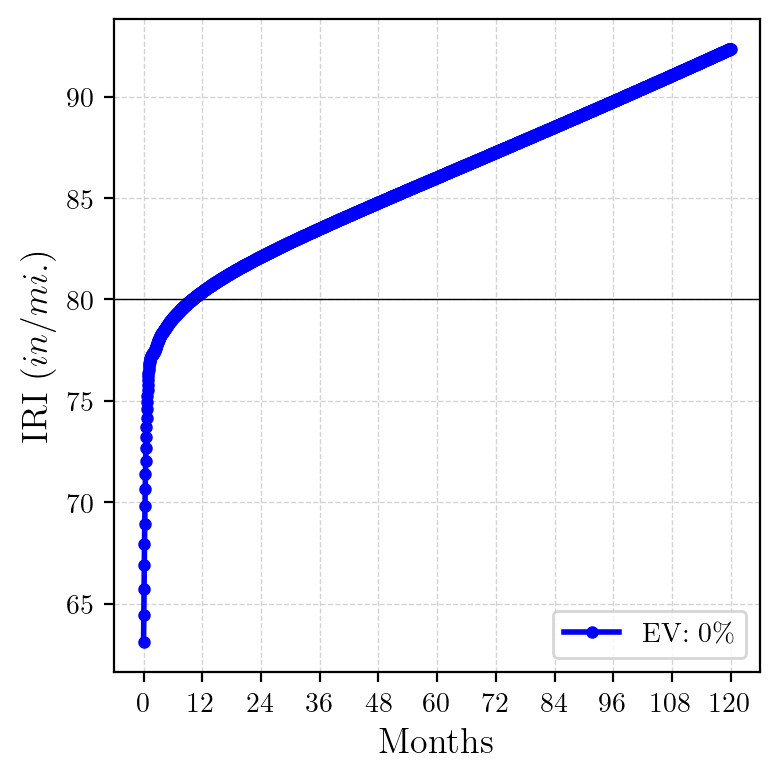

In [64]:
# Plot IRI_max
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

x = np.arange(len(IRI_max))
y = IRI_max
spl = make_interp_spline(x, y, k=5)  # k is the degree of the spline
x_smooth = np.linspace(x.min(), x.max(), 2500)
y_smooth = spl(x_smooth)

fig, axs = plt.subplots(1, 1, figsize=(4, 4), dpi=200)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.plot(x_smooth, y_smooth, '-b', marker='o', markeredgecolor='blue', markersize=4, markeredgewidth=0.5, linewidth=2.0, zorder=1, label='EV: $0\%$')  # Smoothed Line
#plt.scatter(np.arange(len(IRI_max)), IRI_max, color='b', edgecolors='k', marker='o', linewidths=0.5, s=30, zorder=2)
plt.axhline(80, color='black', linewidth=0.5)

plt.xlabel('Months', fontsize=13)
plt.ylabel('IRI ($in/mi.$)', fontsize=13)

plt.xticks(np.arange(0, len(IRI_max), 12), fontsize=10)

plt.grid(color='lightgrey', linestyle='--', linewidth=0.50, zorder=0)
plt.gca().set_axisbelow(True)  # Sends gridlines to the back
plt.legend(loc = 'lower right', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()